## Лабораторная работа №1

Для начала узнаем номера, которые нужно сделать

In [1]:
from zlib import crc32
import numpy as np

if __name__=='__main__':
    mail = input('enter phystech e-mail\n') 
    to_hash =  mail.strip().split('@')[0]    
    h = crc32(to_hash.encode('utf-8'))
    seed = h%(2**32-1)
    rs = np.random.RandomState(seed)
    task1 = rs.randint(low=1, high=5)
    task2 = rs.randint(low=1, high=5)
    task3 = rs.randint(low=1, high=5)
    task4 = rs.randint(low=1, high=4)
    print ('Your tasks are 1.{}, 2.{}, 3.{}, 4.{}'.format(task1, task2, task3, task4))

enter phystech e-mail
titov.vn@phystech.edu
Your tasks are 1.1, 2.4, 3.3, 4.2


-----

In [1]:
colors = {
    'start_c': '\033[96m',
    'end_c': '\033[0m'
}

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as st

import pandas as pd

In [11]:
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.stats.multitest import multipletests

In [4]:
matplotlib.rc('figure', figsize=(20, 20))

## Задание 1.1

Проверить мощность и консервативность критериев Лиллиефорса, Харке-Бера, Шапиро-Улика для выборок из следующих распределений:

- Нормальное
- Лапласа
- Стьюдента
- Усеченное нормальное распределение (модуль каждого элемента выборки не превосходит 2)


In [60]:
def generate_sample(distribution, size):
    return distribution(size)

In [61]:
dists = {
    'normal': st.norm(loc=1, scale=2).rvs,
    'laplace': st.laplace().rvs,
    'student': st.t(df=2).rvs,
    'tnormal': st.truncnorm(a=-2, b=2, loc=0, scale=1).rvs
}

In [62]:
criterions = {
    'lilieforce': lilliefors,
    'harke_bera': st.jarque_bera,
    'shapiro': st.shapiro
}

#### Исследуем консервативность критериев

Будем генерировать выборки размеров 100, для каждой пары `<распределение-критерий>` найдем количество ```false_positive``` ответов

In [63]:
dists.keys()

dict_keys(['normal', 'laplace', 'student', 'tnormal'])

In [64]:
H0 = ['normal']
other = ['laplace', 'student', 'tnormal']

Для начала рассмотрим случай, когда выборки поступают только из нормального распределения

In [73]:
n = 40
N_exp = 100

answer_multiple = dict()
answer_no_multi = dict()
for criterion in criterions.keys():
    
    dist = H0[0]
    p_vals = []
    
    fp = 0
    for _ in range(N_exp):
        
        data = generate_sample(dists[dist], n)
        __, p_val = criterions[criterion](data)
        if p_val <= 0.05:
            fp += 1
        p_vals.append(p_val)
        
    rej, _, _, _ = multipletests(p_vals, method='holm')
    answer_multiple[criterion] = np.mean(rej)
    answer_no_multi[criterion] = fp/N_exp

In [74]:
print('HOLM correction')
print('-'*57)
for test_name in answer_multiple.keys():
    print('For {start_c}{}{end_c} test actual false_positive_rate -- {:0.3f}'.format(test_name, 
                                                                                     answer_multiple[test_name], 
                                                                                    **colors))
    print('-'*57)

print('\n\n')

print('no FWER controlling')
print('-'*57)
for test_name in answer_no_multi.keys():
    print('For {start_c}{}{end_c} test actual false_positive_rate -- {:0.3f}'.format(test_name, 
                                                                                     answer_no_multi[test_name], 
                                                                                    **colors))
    print('-'*57)

HOLM correction
---------------------------------------------------------
For lilieforce test actual false_positive_rate -- 0.000
---------------------------------------------------------
For harke_bera test actual false_positive_rate -- 0.020
---------------------------------------------------------
For shapiro test actual false_positive_rate -- 0.000
---------------------------------------------------------



no FWER controlling
---------------------------------------------------------
For lilieforce test actual false_positive_rate -- 0.090
---------------------------------------------------------
For harke_bera test actual false_positive_rate -- 0.030
---------------------------------------------------------
For shapiro test actual false_positive_rate -- 0.020
---------------------------------------------------------


Как можно увидеть из полученных результатов - все тесты кроме лилиефорса для проверки "Нормальности" распределения консервативны на достаточно маленьком размере выборки, из всех с наименьшим фактическим уровнем значимости оказался тест Шапиро-Уилка.

Учитывая множественную проверку и делая поправку, мы получим еще более меньший фактический уровень значимости, то есть мы не увеличим получившиеся оценки и поэтому можно смело говорить, что данные критерии с хорошим качеством детектируют нормальность выборки.

Теперь рассмотрим вариант, когда выборки подаются из разных распределений

Cэмплируем случайно распределения, будем делать поправку по методу Холма

In [390]:
def get_pvals(n_size, n_exp):
    answer = dict()

    for criterion in criterions.keys():

        p_vals = []
        y_true = []
        for i in range(n_exp):

            dist = np.random.choice(list(dists.keys()), p=[0.7, 0.1, 0.1, 0.1])
            H0_flag = not dist in H0
            y_true.append(H0_flag)
            
            data = generate_sample(dists[dist], n_size)
            __, p_val = criterions[criterion](data)

            p_vals.append(p_val)

        answer[criterion] = {
            'true': y_true,
            'p_vals': p_vals
        }
        
    return answer

In [468]:
def process_pvals(answer, method='holm'):
    processed = dict()
    
    for key in answer.keys():
        rejected, _, _, _ = multipletests(answer[key]['p_vals'], method=method)
        pred = np.array(rejected, dtype=int)
        y_true = np.array(answer[key]['true'], dtype=int)
        S = pred @ y_true
        U = abs(1 - pred) @ abs(1 - y_true)
        V = pred @ abs(1 - y_true)
        T = abs(1 - pred) @ y_true
        processed[key] = {
            'Принятых H_0': [U, T, U + T],
            'Отвергнутых H_0': [V, S, V + S],
            'Всего': [U + V, T + S, U + T + V + S]
        }
        
    return processed

In [469]:
ans = process_pvals(get_pvals(100, 50))

/Users/macder/.pyenv/versions/3.7.2/lib/python3.7/site-packages/statsmodels/stats/_lilliefors.py:272: FutureWarning: The default pvalmethod will change from "approx" to "table" after 0.11. The "table" method uses values from a very large simulation and is more accurate.  Explicitly set this parameter to "approx" or "table" to silence this warning
  warnings.warn(msg, FutureWarning)


In [470]:
tab = pd.DataFrame.from_dict(ans['shapiro'], orient='index', columns=['Верных H_0', 'Неверных H_0', 'Всего'])

In [474]:
tab

Верных H_0  Неверных H_0  Всего
Принятых H_0             32             8     40
Отвергнутых H_0           0            10     10
Всего                    32            18     50

In [475]:
tab.iloc[1, 0]/tab.iloc[2, 0] #достигаемые уровни

0.0

In [476]:
tab.iloc[1, 1]/tab.iloc[2, 1]   # мощность

0.5555555555555556

Рассмотрим фиксированный размер выборки, но будем менять количество экспериментов c поправкой Холма

In [491]:
iterator = np.arange(100, 1001, 50)

In [492]:
answers = []
for n_exp in iterator:
    pvals = get_pvals(100, n_exp)
    ans = process_pvals(pvals)
    to_add = dict()
    for key in criterions.keys():
        tab = pd.DataFrame.from_dict(ans[key], orient='index', columns=['Верных H_0', 'Неверных H_0', 'Всего'])
        to_add[key] = {'fpr': tab.iloc[1, 0]/tab.iloc[2, 0], 
                        'tpr': tab.iloc[1, 1]/tab.iloc[2, 1]}
    answers.append(to_add)

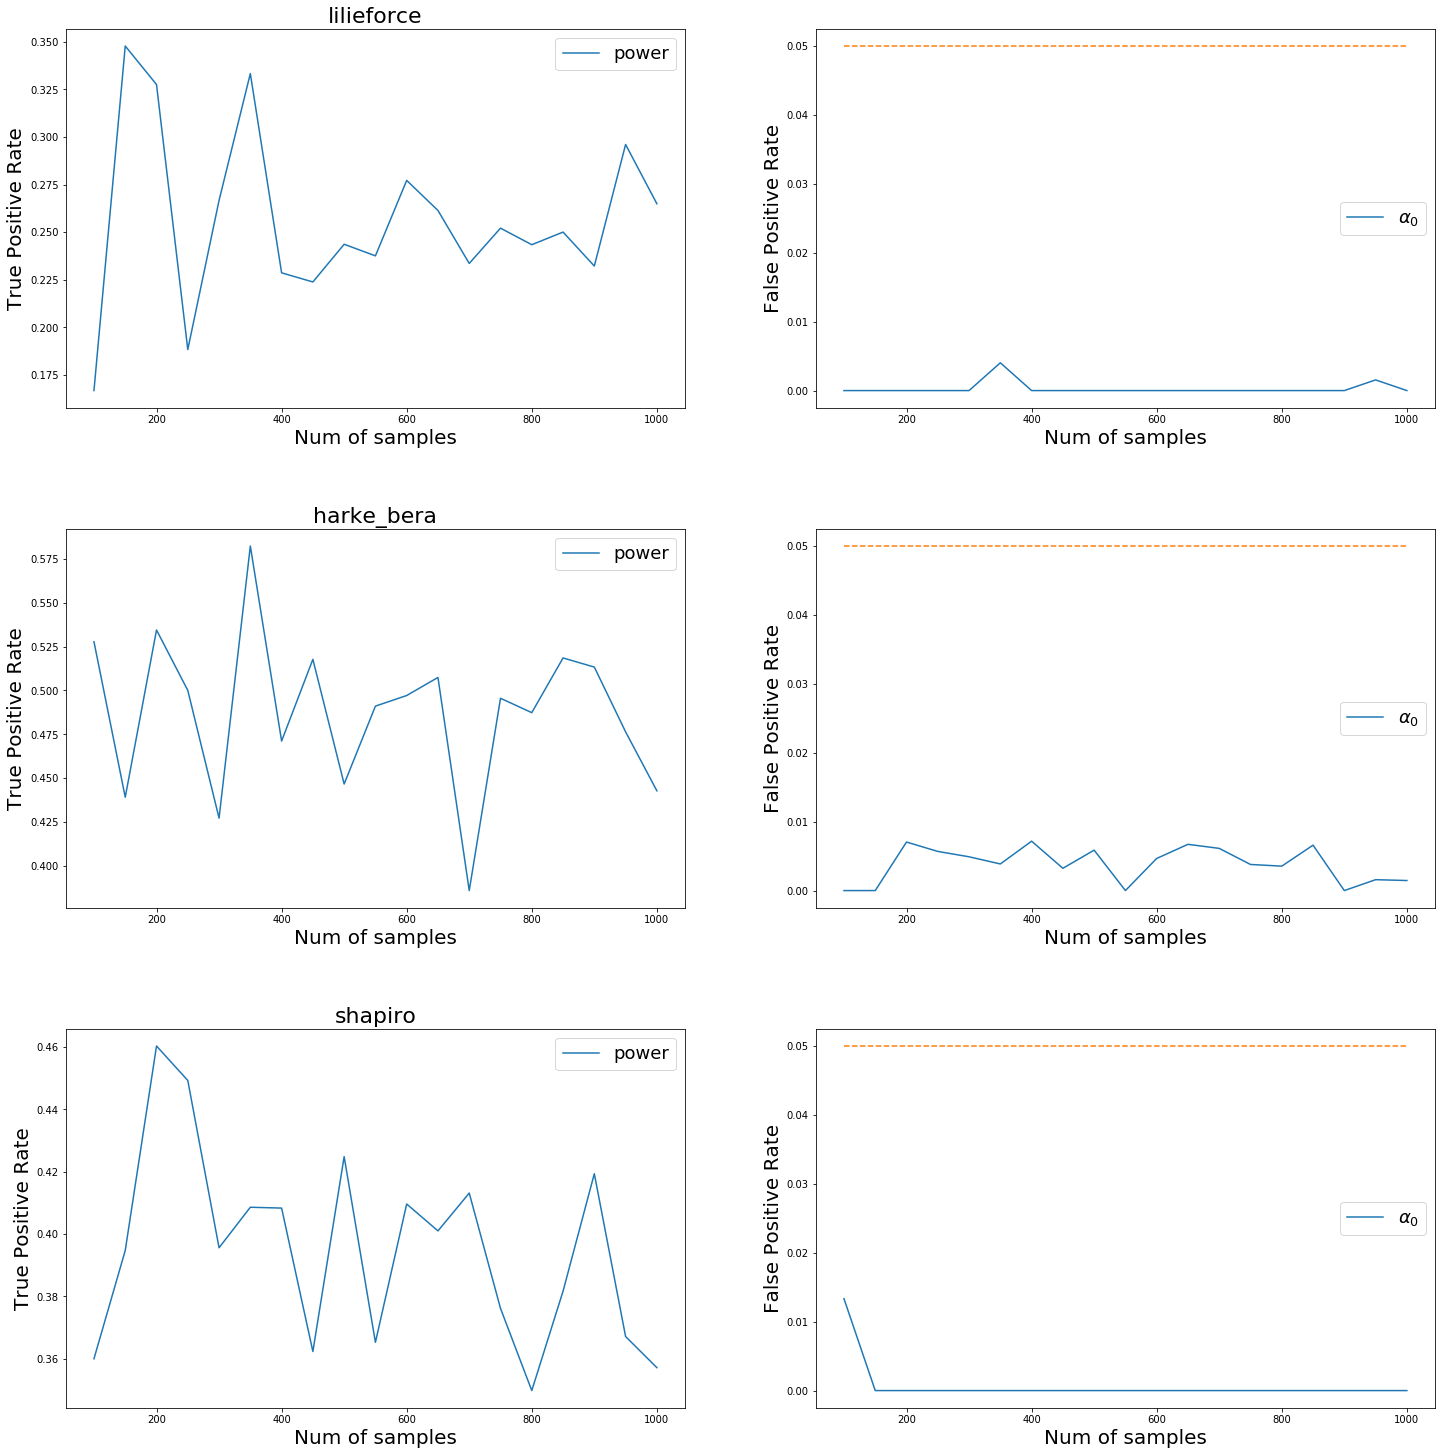

In [494]:
fig, ax = plt.subplots(3, 2)
fig.tight_layout(pad=2, w_pad=10, h_pad=10)

for idx, name in enumerate(criterions.keys()):
    x = iterator
    tpr_rate = []
    fpr_rate = []
    for ans in answers:
        tpr_rate.append(ans[name]['tpr'])
        fpr_rate.append(ans[name]['fpr'])
    ax[idx, 0].set_ylabel("True Positive Rate", fontsize=20)
    ax[idx, 1].set_ylabel("False Positive Rate", fontsize=20)
    ax[idx, 0].set_xlabel("Num of samples", fontsize=20)
    ax[idx, 1].set_xlabel("Num of samples", fontsize=20)
    ax[idx, 0].plot(x, tpr_rate, label='power')
    ax[idx, 1].plot(x, fpr_rate, label=r'$\alpha_0$')
    ax[idx, 0].legend(fontsize=18)
    ax[idx, 1].legend(fontsize=18)
    ax[idx, 0].set_title(name, fontsize=22)
    ax[idx, 1].plot([iterator[0], iterator[-1]], [0.05, 0.05], ls='--')

Из графиков трудно сделать какой-то вывод, потому что во всех случаях колебания не имеют видимого тренда

Все критерии проявили консервативность

In [487]:
iterator = np.arange(20, 500, 30)

In [488]:
answers = []
for val in iterator:
    pvals = get_pvals(val, 100)
    ans = process_pvals(pvals)
    to_add = dict()
    for key in criterions.keys():
        tab = pd.DataFrame.from_dict(ans[key], orient='index', columns=['Верных H_0', 'Неверных H_0', 'Всего'])
        to_add[key] = {'fpr': tab.iloc[1, 0]/tab.iloc[2, 0], 
                        'tpr': tab.iloc[1, 1]/tab.iloc[2, 1]}
    answers.append(to_add)

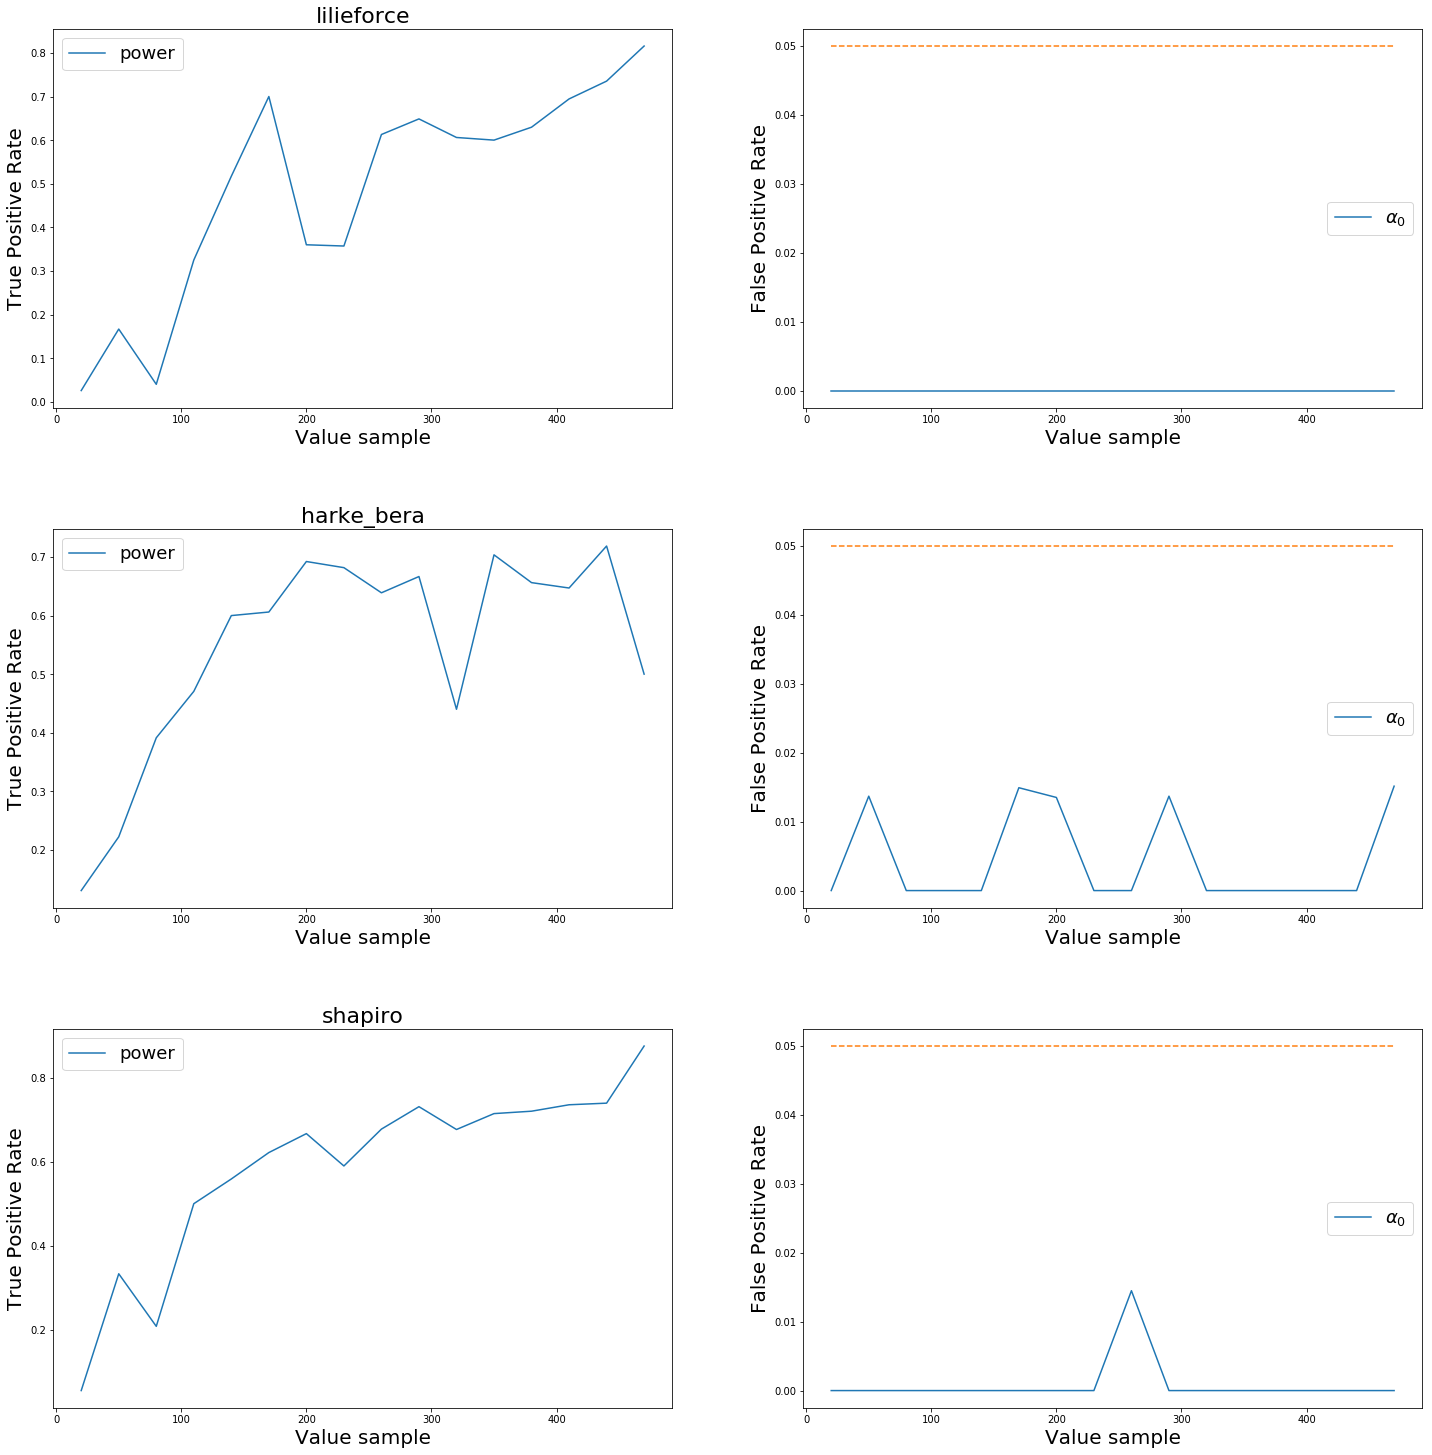

In [489]:
fig, ax = plt.subplots(3, 2)
fig.tight_layout(pad=2, w_pad=10, h_pad=10)

for idx, name in enumerate(criterions.keys()):
    x = iterator
    tpr_rate = []
    fpr_rate = []
    for ans in answers:
        tpr_rate.append(ans[name]['tpr'])
        fpr_rate.append(ans[name]['fpr'])
    ax[idx, 0].set_ylabel("True Positive Rate", fontsize=20)
    ax[idx, 1].set_ylabel("False Positive Rate", fontsize=20)
    ax[idx, 0].set_xlabel("Value sample", fontsize=20)
    ax[idx, 1].set_xlabel("Value sample", fontsize=20)
    ax[idx, 0].plot(x, tpr_rate, label='power')
    ax[idx, 1].plot(x, fpr_rate, label=r'$\alpha_0$')
    ax[idx, 0].legend(fontsize=18)
    ax[idx, 1].legend(fontsize=18)
    ax[idx, 1].plot([iterator[0], iterator[-1]], [0.05, 0.05], ls='--')
    ax[idx, 0].set_title(name, fontsize=22)

### Выводы:

- При увеличении количества проверяемых гипотез менее мощным из всех критериев оказался критерий Лилиефорса, причем мощности всех критериев колеблются и нельзя выделить какой-то тренд, то есть при работе со многими гипотезами данные критерии ведут себя не предсказуемо

- При увеличении размера выборки самым мощным оказался тест Шапиро, тест Лилиефорса оказался немногим менее мощным.

- В ходе эксперимента все критерии проявили себя как консервативные

----

## Задание 3.1

Предложить метод выбора наиболее важных признаков для логистической регрессии на основе изученных методов прикладной статистики. Осуществить выбор.

In [185]:
from sklearn.datasets import load_wine

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.model_selection import train_test_split

In [186]:
dataset = load_wine()

In [187]:
print(dataset["DESCR"])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

In [188]:
X, y = load_wine(return_X_y=True)

In [273]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=10)

Попробуем отобрать кандидатов на "признаки" с помощью приращения roc_auc метрики

Будем жадно отбирать до тех пор, пока добавление предыдущего не ухудшит качество

In [274]:
n = X_train.shape[0]

In [275]:
idxs = []
last = 0
curr_roc = 0.1
while (last < curr_roc):
    last = curr_roc
    max_idxs = []
    for feature_idx in range(X_train.shape[1]):
        if feature_idx in idxs:
            continue
        new_ids = idxs + [feature_idx]
        
        new_X = X_train[:, new_ids]
        model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=10000).fit(new_X, y_train)
        score = roc_auc_score(y_train, model.predict_proba(new_X), multi_class='ovo', average='macro')
        
        max_idxs.append([feature_idx, score])
        
    curr_roc = sorted(max_idxs, key=lambda x: x[1], reverse=True)[0][1]
    new_id = sorted(max_idxs, key=lambda x: x[1], reverse=True)[0][0]
    idxs.append(new_id)

In [276]:
idxs

[6, 0, 9, 11, 1, 5, 2, 8]

In [277]:
model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=10000).fit(X_train, y_train)
score = roc_auc_score(y_train, model.predict_proba(X_train), multi_class='ovo', average='macro')
score_test = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovo', average='macro')


print("no feature selection, roc_auc_train = {:.5f}".format(score))
print("no feature selection, roc_auc_test = {:.5f}".format(score_test))

no feature selection, roc_auc_train = 0.98824
no feature selection, roc_auc_test = 0.99570


In [278]:
new_X = X_train[:, idxs]
model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=10000).fit(new_X, y_train)
score = roc_auc_score(y_train, model.predict_proba(new_X), multi_class='ovo', average='macro')
score_test = roc_auc_score(y_test, model.predict_proba(X_test[:, idxs]), multi_class='ovo', average='macro')


print("feature selection, roc_auc_train = {:.5f}".format(score))
print("feature selection, roc_auc_test = {:.5f}".format(score_test))

feature selection, roc_auc_train = 0.99566
feature selection, roc_auc_test = 0.99074


Видим, что убрав лишние признаки модель смогла лучше предсказывать классы на трейне, но на тесте качество упало

Теперь с помощью бутстрепа оценим статистическую заметность увеличения прироста roc_auc

- Для $N$ бутстреп выборок при добавлении $j$-го признака подсчитаем $N$ roc_auc метрик.
- Для каждой выборки с добавленными признаками проверим гипотезу о том, равны ли средние значения или нет, если статистически критерий детектирует различие в roc_auc, то добавляем данный признак в список

In [279]:
idxs # порядок добавленных признаков, которые давали наибольший прирост roc_auc

[6, 0, 9, 11, 1, 5, 2, 8]

In [280]:
bootstrap_size = 100

In [281]:
rocs = []
for i in range(1, len(idxs) + 1):
    rocs_to_append = []
    new_X = X_train[:, idxs[:i]]
    
    for _ in range(bootstrap_size):
        new_idxs = np.random.choice(n, n, replace=True)
        
        X_bootstrap = new_X[new_idxs]
        new_y = y[new_idxs]
        model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=10000).fit(X_bootstrap, new_y)
        score = roc_auc_score(new_y, model.predict_proba(X_bootstrap), multi_class='ovo', average='macro')
        rocs_to_append.append(score)
    rocs.append(rocs_to_append)

In [282]:
roc_X = np.array(rocs).T

Таким образом, для каждого добавленного признака мы получили roc_auc на бустреп выборках.

Попробуем оценить с помощью критерия Уилкоксона для связанных выборок (так как выборки имеют связь по общим параметрам) определить отличаются ли средние значения.
Так же попробуем применить критерий Стьюдента для связанных выборов, проверив перед этим нормально полученных значений с помощью теста Шапиро

In [285]:
# оценим нормальность

p_shap = []
for i in range(len(idxs)):
    _, p_val = st.shapiro(roc_X[:, i])
    p_shap.append(p_val)

In [286]:
rejected, _, _, _ = multipletests(p_shap, method='holm')

In [287]:
rejected

array([ True, False, False, False, False, False, False, False])

Только одна гипотеза была отклонена, поэтому попробуем использовать критерий Стьюдента для связанных выборок

In [288]:
p_values = []
p_s_ttest = []
for i in range(len(idxs) - 1):
    _, p_val = st.wilcoxon(roc_X[:, i], roc_X[:,i + 1])
    p_values.append(p_val)
    _, p_val = st.ttest_rel(roc_X[:, i], roc_X[:,i + 1])
    p_s_ttest.append(p_val)
                                                               

In [289]:
print("wilcoxon test: ")
print("p_value for gain of _____ feature is ")
for i in range(len(p_values)):
    print("____________________ {}th _______ ___ {:.5f}".format(idxs[i + 1], p_values[i]))
print('-'*60)

print("ttest_rel: ")
print("p_value for gain of _____ feature is ")
for i in range(len(p_s_ttest)):
    print("____________________ {}th _______ ___ {:.5f}".format(idxs[i + 1], p_s_ttest[i]))

wilcoxon test: 
p_value for gain of _____ feature is 
____________________ 0th _______ ___ 0.00000
____________________ 9th _______ ___ 0.00001
____________________ 11th _______ ___ 0.00019
____________________ 1th _______ ___ 0.00379
____________________ 5th _______ ___ 0.00042
____________________ 2th _______ ___ 0.00121
____________________ 8th _______ ___ 0.22882
------------------------------------------------------------
ttest_rel: 
p_value for gain of _____ feature is 
____________________ 0th _______ ___ 0.00000
____________________ 9th _______ ___ 0.00002
____________________ 11th _______ ___ 0.00005
____________________ 1th _______ ___ 0.00138
____________________ 5th _______ ___ 0.00050
____________________ 2th _______ ___ 0.00226
____________________ 8th _______ ___ 0.20266


Видим, что оба теста одинаково отклоняют или принимают гипотезы, поэтому следуя результатам тестов отберем признаки 6, 0, 9, 11, 1, 5, 2 для предсказания

Итого: 6, 0, 9, 11, 1, 5, 2

Features:

- Alcohol - 0 
- Malic acid - 1
- Ash - 2
- Alcalinity of ash - 3 
- Magnesium - 4
- Total phenols - 5 
- Flavanoids - 6
- Nonflavanoid phenols - 7
- Proanthocyanins - 8
- Color intensity - 9
- Hue - 10
- OD280/OD315 of diluted wines - 11
- Proline - 12

In [290]:
selected_idxs = [6, 0, 9, 11, 1, 5, 2]

In [291]:
final_X = X_train[:, selected_idxs]
model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=10000).fit(final_X, y_train)
score = roc_auc_score(y_train, model.predict_proba(final_X), multi_class='ovo', average='macro')
score_test = roc_auc_score(y_test, model.predict_proba(X_test[:, selected_idxs]), multi_class='ovo', average='macro')


print("final feature selection, roc_auc_train = {:.5f}".format(score))
print("final feature selection, roc_auc_test = {:.5f}".format(score_test))

final feature selection, roc_auc_train = 0.99625
final feature selection, roc_auc_test = 0.99339


### Выводы

- Отбор признаков - важная задача, так как во-первых, позволяет улучшить качество модели, а во-вторых, позволяет лучше понять, на какие параметры и признаки важно смотреть во время исследований

- Бутстреп сэмплирование выборки позволяет с большей уверенностью проводить отбор

- Предложенный метод справился с повышением качества (train: 0.98824 -> 0.99625),__   однако на тесте качество немного уменьшилось (0.99570 -> 0.99339)

- С уменьшением мощности датасета неверно предсказанная метка сильнее влияет на качество, в нашем случае (178 элементов: 151 - train, 27 - test) датасет оказался слишком мал, чтобы тестовая выборка была репрезентативна, уменьшение качества на тесте могло произойти по этому причине 

-----